# Решение задачи кластеризации торговых точек нейросетевыми методами

In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# !pip install tsfresh

In [7]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split
from collections import defaultdict

sns.set(style='darkgrid')
filterwarnings('ignore')

In [5]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [5]:
import pandas as pd
from prophet import Prophet

In [ ]:
df_product = pd.read_csv('/content/drive/MyDrive/CourseWorkSAS/product_dict_df_sorted.csv', sep=';')
df_product.fillna('Неизвестный класс', inplace=True)
df_product.loc[df_product['PRODUCT_LVL_NM1'] == '04-10', 'PRODUCT_LVL_NM1'] = 'Неизвестный класс'
df_product[100:105]

,PRODUCT_ID,PRODUCT_NM,PRODUCT_LVL_NM1,PRODUCT_LVL_NM2,PRODUCT_LVL_NM3,PRODUCT_LVL_NM4,FAKE_ID
100,157448,Решетка радиаторная 600х1200 мм слон,Инженерные системы,Вентиляция,Вентиляция,Решетки радиаторные,100
101,75608,Лючок пластиковый 200х200 с защелкой,Инженерные системы,Вентиляция,Вентиляция,Лючки ревизионные,101
102,43328,Люк под плитку Слава 600х600 (ШхВ) станд,Инженерные системы,Вентиляция,Вентиляция,Лючки ревизионные,102
103,235018,Панель монтаж. для КСРМ 500х590 (уп.2шт),Инженерные системы,Вентиляция,Вентиляция,Комплексные системы вентиляции,103
104,84075,Решетка вентиляционная 600*600 нак.С-003,Инженерные системы,Вентиляция,Вентиляция,Решетки вентиляционные,104


In [8]:
df_sales = pd.read_csv('df_pop_week_sales_qty.csv', sep=';')[:-15]
# df_revenue = pd.read_csv('/content/drive/MyDrive/CourseWorkSAS/df_pop_week_revenue.csv', sep=';')[:-15]

df_sales.head(5)

,WEEK,STORE_ID,221,405,410,506,507,746,978,1207,...,256746,256861,258055,258580,259313,259718,260634,261354,262752,263059
0,2018-01-01,21,3.0,2.0,7.0,1.0,2.0,6.0,2.0,2.0,...,11.0,13.0,40.0,6.0,179.0,145.0,5.0,1.0,16.0,8.0
1,2018-01-01,22,0.0,3.0,3.0,4.0,2.0,3.0,3.0,5.0,...,4.0,5.0,3.0,13.0,111.0,38.0,5.0,2.0,3.0,6.0
2,2018-01-01,23,1.0,3.0,4.0,0.0,1.0,5.0,0.0,0.0,...,68.0,8.0,12.0,2.0,67.0,164.0,2.0,4.0,6.0,7.0
3,2018-01-01,24,1.0,1.0,4.0,1.0,4.0,3.0,4.0,1.0,...,3.0,10.0,16.0,5.0,130.0,123.0,2.0,4.0,7.0,4.0
4,2018-01-01,25,3.0,6.0,4.0,3.0,5.0,6.0,6.0,2.0,...,18.0,3.0,46.0,9.0,9.5,18.0,4.0,2.0,15.0,3.0


In [182]:
(df_sales['WEEK'].shape[0] - 26) * 15

25935

In [9]:
def exract_item_by_stores(df, item_id):
    stores_list = df['STORE_ID'].unique()
    dates_list = df['WEEK'].unique()
    df_item = df[['WEEK', 'STORE_ID', str(item_id)]]
    df_item_stores = pd.DataFrame(index=dates_list, columns=stores_list)
    for st in stores_list:
        df_item_stores[st] = df_item[df_item['STORE_ID'] == st][str(item_id)].values
    return df_item_stores

In [10]:
item_name = 'Услуга доставки'
item_id = 223162

In [11]:
features_df = exract_item_by_stores(df_sales, item_id)
features_df.head(5)

,21,22,23,24,25,121,123,124,127,131,144,146,153,154,244
2018-01-01,32.0,36.0,30.0,47.0,8.0,36.0,47.0,28.0,22.0,33.0,41.0,28.0,23.0,37.0,14.0
2018-01-08,35.0,44.0,43.0,40.0,9.0,46.0,463.0,29.0,24.0,29.0,56.0,38.0,40.0,46.0,31.0
2018-01-15,38.0,48.0,40.0,44.0,14.0,50.0,56.0,33.0,39.0,28.0,91.0,35.0,28.0,53.0,26.0
2018-01-22,40.0,43.0,29.0,53.0,10.0,48.0,47.0,40.0,48.0,45.0,74.0,42.0,36.0,51.0,27.0
2018-01-29,38.0,47.0,33.0,33.0,10.0,53.0,41.0,34.0,34.0,34.0,91.0,42.0,37.0,42.0,21.0


In [93]:
SEQUENCE_LENGTH = 26

In [81]:
def cut_series_X_y(input_data: pd.DataFrame, target_column, seq_length):
    sequences = []
    labels = []
    for i in tqdm(range(len(input_data) - seq_length)):
        for store in input_data.columns:
            sequences += [input_data[store][i:i+seq_length]]
            labels += [input_data[store][i + seq_length]]
    return np.array(sequences), np.array(labels)

Можно экспериментировать с составом магазинов и (возможно) продуктов одной категории

In [82]:
target_store = 144

seqs_full, y_full = cut_series_X_y(features_df, target_store, SEQUENCE_LENGTH)

100%|██████████| 91/91 [00:00<00:00, 1708.11it/s]


In [187]:
ts_index = []

for i in features_df.index[26:]:
    for store in features_df.columns:
        ts_index += [(i, store)]

In [188]:
len(ts_index)

1365

## Prophet Prediction

In [195]:
train_df = features_df[:train_size]
test_df = features_df[train_size - SEQUENCE_LENGTH - 1:]
pred_df = features_df[train_size:]
train_df.shape, test_df.shape, pred_df.shape

((78, 15), (66, 15), (39, 15))

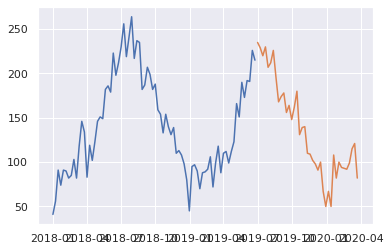

In [61]:
plt.plot(pd.to_datetime(train_df.index), train_df[144])
plt.plot(pd.to_datetime(test_df[SEQUENCE_LENGTH + 1:].index), test_df[SEQUENCE_LENGTH + 1:][144])


In [32]:
ds_check = train_df[[target_store]].reset_index().rename({'index' : "ds", 144 : 'y'}, axis=1)
ds_check.columns

Index(['ds', 'y'], dtype='object')

In [44]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m.fit(ds_check)

In [63]:
future = pred_df[[target_store]].reset_index().rename({'index' : "ds"}, axis=1)[['ds']]
future.head(3)

,ds
0,2019-07-01
1,2019-07-08
2,2019-07-15


In [64]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-07-01,227.633634,210.500041,244.678700
1,2019-07-08,236.540409,220.238799,253.525083
2,2019-07-15,240.909168,224.349432,258.430419
3,2019-07-22,241.189148,223.975151,257.380929
4,2019-07-29,240.892486,223.653212,259.057557


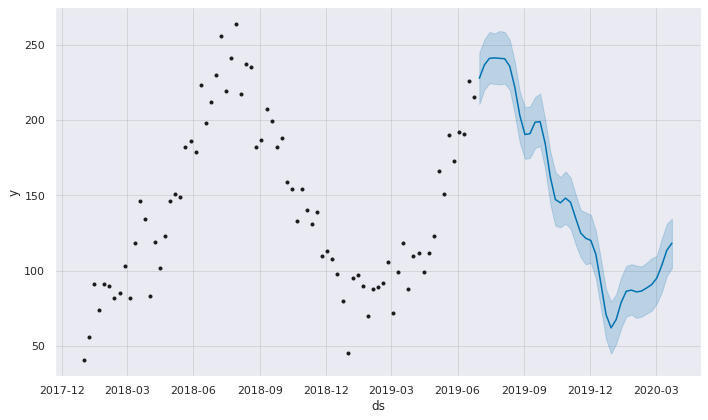

In [79]:
fig1 = m.plot(forecast)

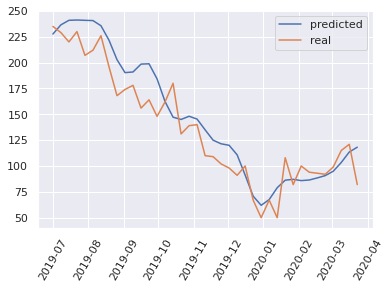

In [65]:
dates = pd.to_datetime(forecast['ds'])
plt.plot(dates, forecast['yhat'], "-", label='predicted')
plt.plot(dates, pred_df[target_store], "-", label='real')
plt.xticks(rotation=60)
plt.legend();

In [ ]:
def predict_with_prophet():
    pass

In [69]:
MAE(pred_df[target_store], forecast['yhat'])

16.77519967497432

In [70]:
MAPE(pred_df[target_store], forecast['yhat'])

0.13720349975179355

## tsfresh + ML models

In [ ]:
# !pip install tsfresh

In [129]:
# импортируем необходимые функции из библиотеки
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.inspection import permutation_importance
from tsfresh.feature_extraction import settings

# для построения моделей воспользуемся sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [85]:
data = seqs_full
data_long = pd.DataFrame({0: data.flatten(),
                          1: np.arange(data.shape[0]).repeat(data.shape[1])})
print(data_long.shape)
data_long.head()

(35490, 2)


,0,1
0,32.0,0
1,35.0,0
2,38.0,0
3,40.0,0
4,38.0,0


###  Набор признаков 1:  только базовые 

In [20]:
settings_minimal = settings.MinimalFCParameters()

In [120]:
%%time

X_mini = extract_features(data_long, column_id=1, impute_function=impute, default_fc_parameters=settings_minimal)
print(X_mini.shape)

Feature Extraction: 100%|██████████| 228/228 [00:00<00:00, 396.17it/s]


(1365, 10)
CPU times: user 393 ms, sys: 453 ms, total: 846 ms
Wall time: 1.4 s


In [221]:
Xmini_tr, Xmini_test, ym_train, y_test = train_test_split(X_mini, y_full, shuffle=False, test_size=.43)

In [222]:
%%time

regr_model_mini = RandomForestRegressor(n_estimators=50, criterion='absolute_error').fit(Xmini_tr, ym_train)

CPU times: user 1.44 s, sys: 8.09 ms, total: 1.45 s
Wall time: 1.44 s


In [264]:
df_metrics = pd.DataFrame(index=['MAE', 'MAPE'])

In [241]:
y_mini_pred = regr_model_mini.predict(Xmini_test)

MAE(y_test, y_mini_pred), MAPE(y_test, y_mini_pred)

(29.623424190800684, 0.5362207455578397)

In [265]:
df_metrics['minimal_features'] = [MAE(y_test, y_mini_pred), MAPE(y_test, y_mini_pred)]

In [125]:
importances_mini = regr_model_mini.feature_importances_
std_mini = np.std([tree.feature_importances_ for tree in regr_model_mini.estimators_], axis=0)

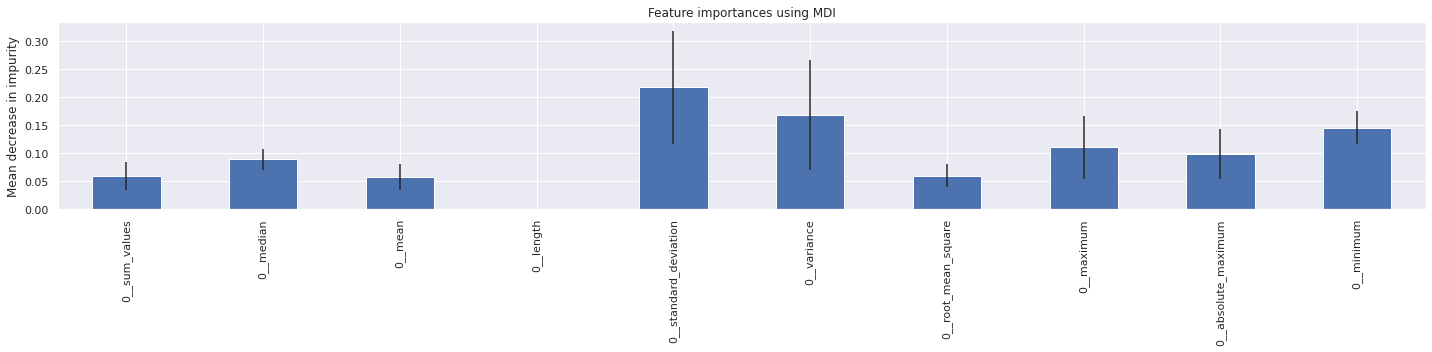

In [126]:
forest_importances = pd.Series(importances_mini, index=X_mini.columns)

fig, ax = plt.subplots(figsize=(20, 5))
forest_importances.plot.bar(yerr=std_mini, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=90)
fig.tight_layout()

In [131]:
result = permutation_importance(regr_model_mini, Xmini_test, y_test, n_repeats=10, random_state=42, n_jobs=5)
forest_importances = pd.Series(result.importances_mean, index=X_mini.columns)

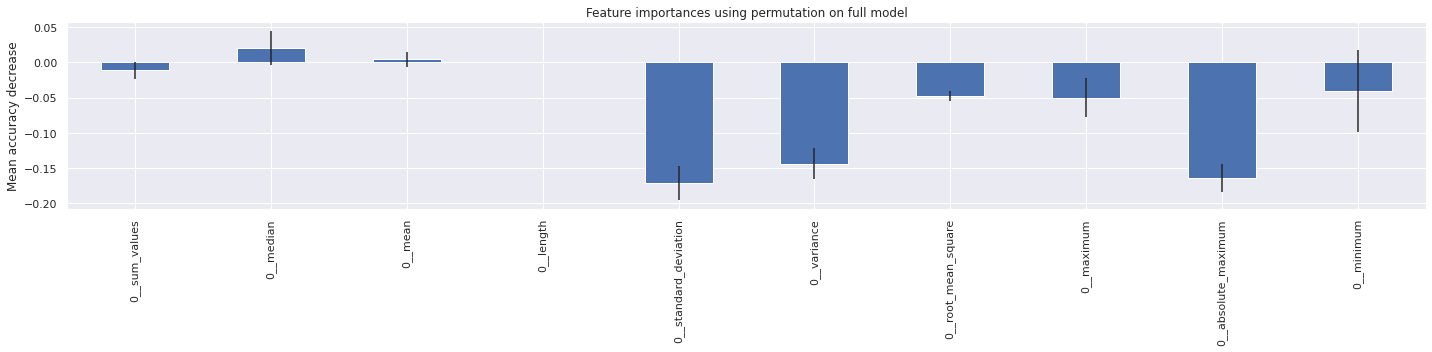

In [132]:
fig, ax = plt.subplots(figsize=(20, 5))

forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [238]:
# картинка с примером предсказания ряда

example_test_ind = np.array([ind for ind, (date, store) in enumerate(ts_index) if store == target_store and ind >= 790]) - len(y_train)

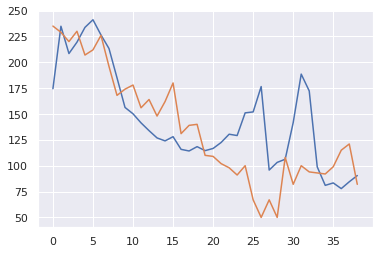

In [242]:
plt.plot(y_mini_pred[example_test_ind])
plt.plot(y_test[example_test_ind])

###  Набор признаков 2:  эффективный в tsfresh

In [139]:
settings_efficient = settings.EfficientFCParameters()
settings_efficient.update(settings_minimal)

In [140]:
X = extract_features(data_long, column_id=1, impute_function=impute, default_fc_parameters=settings_efficient)
print(X.shape)

Feature Extraction: 100%|██████████| 228/228 [00:51<00:00,  4.40it/s]


(1365, 783)


In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y_full, shuffle=False, test_size=.43)

In [225]:
%%time

regr_model = RandomForestRegressor(n_estimators=50, criterion='absolute_error').fit(X_train, y_train)

CPU times: user 49.5 s, sys: 113 ms, total: 49.6 s
Wall time: 49.2 s


In [243]:
y_pred = regr_model.predict(X_test)

MAE(y_test, y_pred), MAPE(y_test, y_pred)

(12.228279386712096, 0.23265947101576512)

In [266]:
df_metrics['efficient_features'] = [MAE(y_test, y_pred), MAPE(y_test, y_pred)]

In [147]:
feature_names = X.columns

In [148]:
importances = regr_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr_model.estimators_], axis=0)

In [149]:
(regr_model.feature_importances_ > 0.01).sum(), (regr_model.feature_importances_ > 0.001).sum()

(8, 141)

In [150]:
imp_idx = (regr_model.feature_importances_ > 0.01)

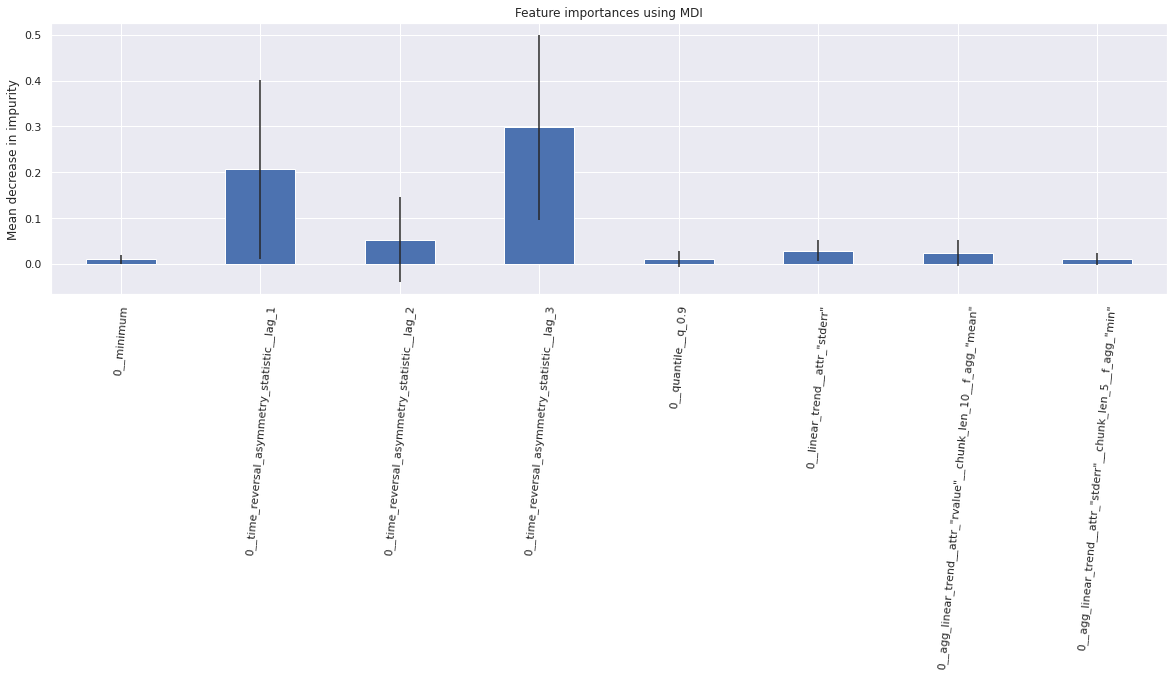

In [151]:
forest_importances = pd.Series(importances[imp_idx], index=feature_names[imp_idx])

fig, ax = plt.subplots(figsize=(20, 5))
forest_importances.plot.bar(yerr=std[imp_idx], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=85)
fig.tight_layout()

In [153]:
result = permutation_importance(regr_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=8)
forest_importances = pd.Series(result.importances_mean, index=X.columns)

In [154]:
perm_imp_idx = (forest_importances > 0.01)
sum(perm_imp_idx)

8

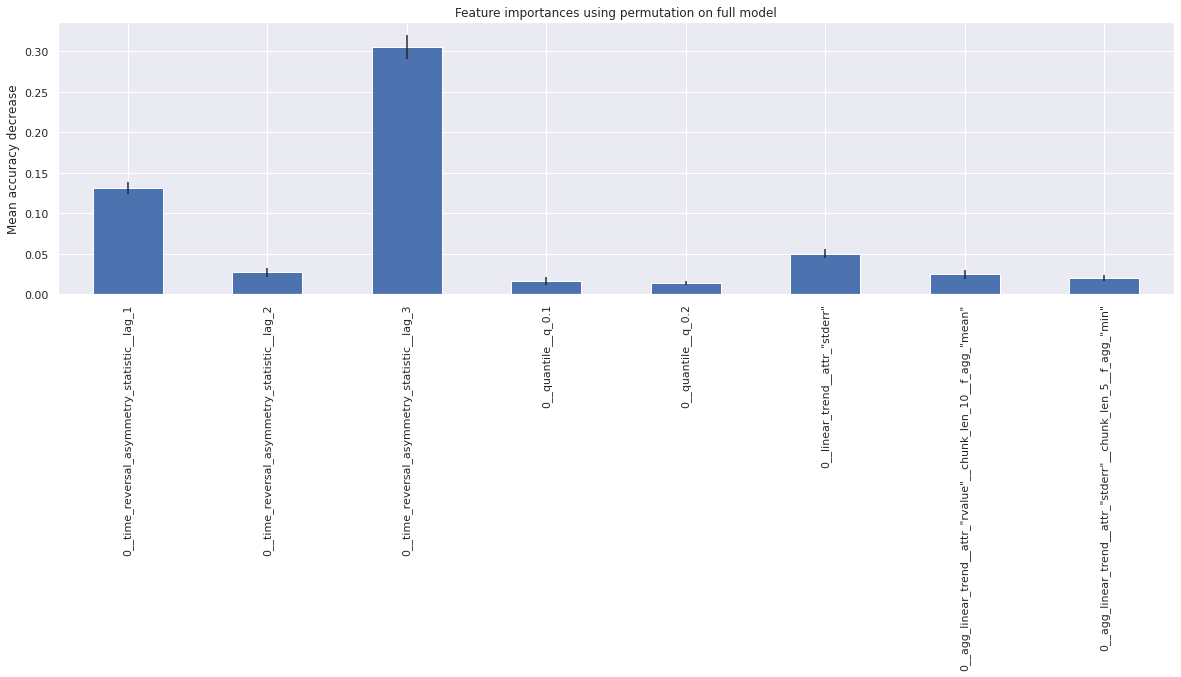

In [155]:
fig, ax = plt.subplots(figsize=(20, 5))

forest_importances[perm_imp_idx].plot.bar(yerr=result.importances_std[perm_imp_idx], ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

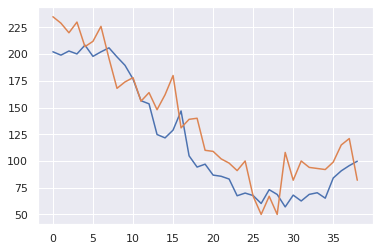

In [244]:
# картинка с предсказанием ряда
plt.plot(y_pred[example_test_ind])
plt.plot(y_test[example_test_ind])

###  Набор признаков 3:  полный в tsfresh

In [137]:
settings_comprehensive = settings.ComprehensiveFCParameters()
settings_comprehensive.update(settings_efficient)

In [138]:
X_large = extract_features(data_long, column_id=1, impute_function=impute, default_fc_parameters=settings_comprehensive)
print(X_large.shape)

Feature Extraction: 100%|██████████| 228/228 [00:55<00:00,  4.14it/s]


(1365, 789)


In [227]:
Xlarge_train, Xlarge_test, y_train, y_test = train_test_split(X_large, y_full, shuffle=False, test_size=.43)

In [230]:
%%time

regr_model_large = RandomForestRegressor(n_estimators=50, criterion='absolute_error').fit(Xlarge_train, y_train)

CPU times: user 1min 40s, sys: 200 ms, total: 1min 40s
Wall time: 1min 39s


In [268]:
y_large_pred = regr_model_large.predict(Xlarge_test)

MAE(y_test, y_large_pred), MAPE(y_test, y_large_pred)

(10.562095400340715, 0.12905307281341316)

In [271]:
df_metrics['comprehensive_optimized'] = [MAE(y_test, y_large_pred), MAPE(y_test, y_large_pred)]

In [272]:
df_metrics

,minimal_features,efficient_features,comprehensive_optimized
MAE,29.623424,12.062095,10.562095
MAPE,0.536221,0.229053,0.129053


In [158]:
feature_names = X_large.columns

In [159]:
importances = regr_model_large.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr_model_large.estimators_], axis=0)

In [160]:
(regr_model_large.feature_importances_ > 0.01).sum(), (regr_model_large.feature_importances_ > 0.001).sum()

(8, 144)

In [161]:
limp_idx = (regr_model_large.feature_importances_ > 0.01)

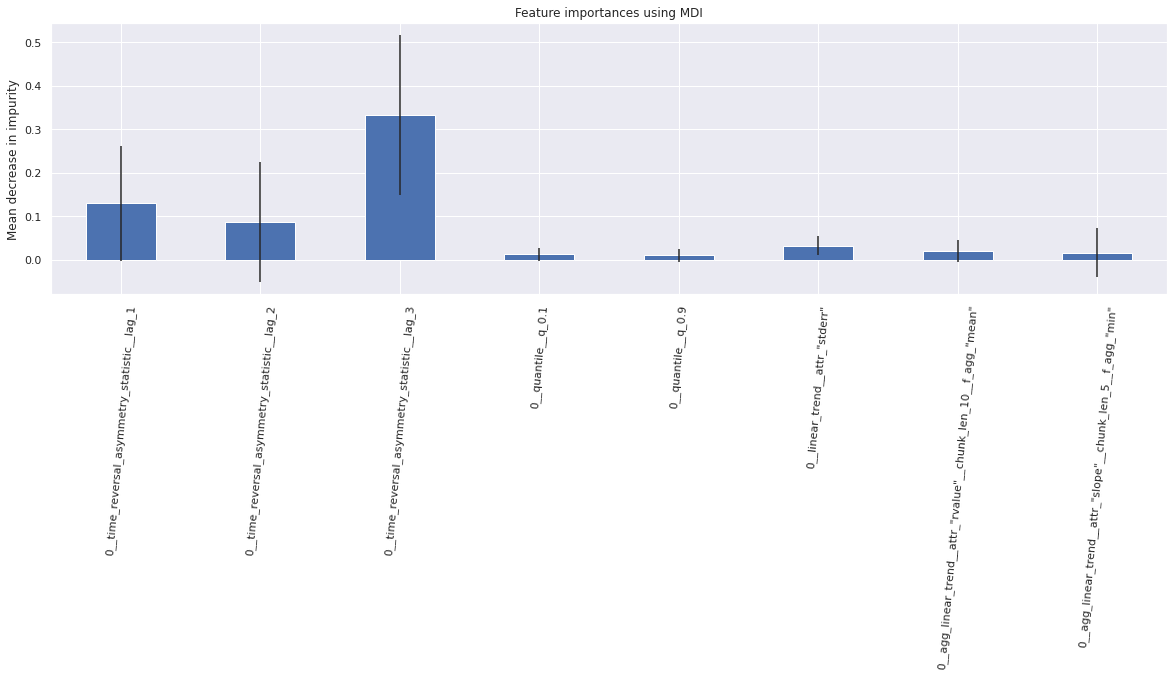

In [162]:
forest_importances = pd.Series(importances[limp_idx], index=feature_names[limp_idx])

fig, ax = plt.subplots(figsize=(20, 5))
forest_importances.plot.bar(yerr=std[limp_idx], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=85)
fig.tight_layout()

In [164]:
result = permutation_importance(regr_model_large, Xlarge_test, y_test, n_repeats=10, random_state=42, n_jobs=10)
forest_importances = pd.Series(result.importances_mean, index=X_large.columns)

In [165]:
lperm_imp_idx = (forest_importances > 0.01)
sum(lperm_imp_idx)

7

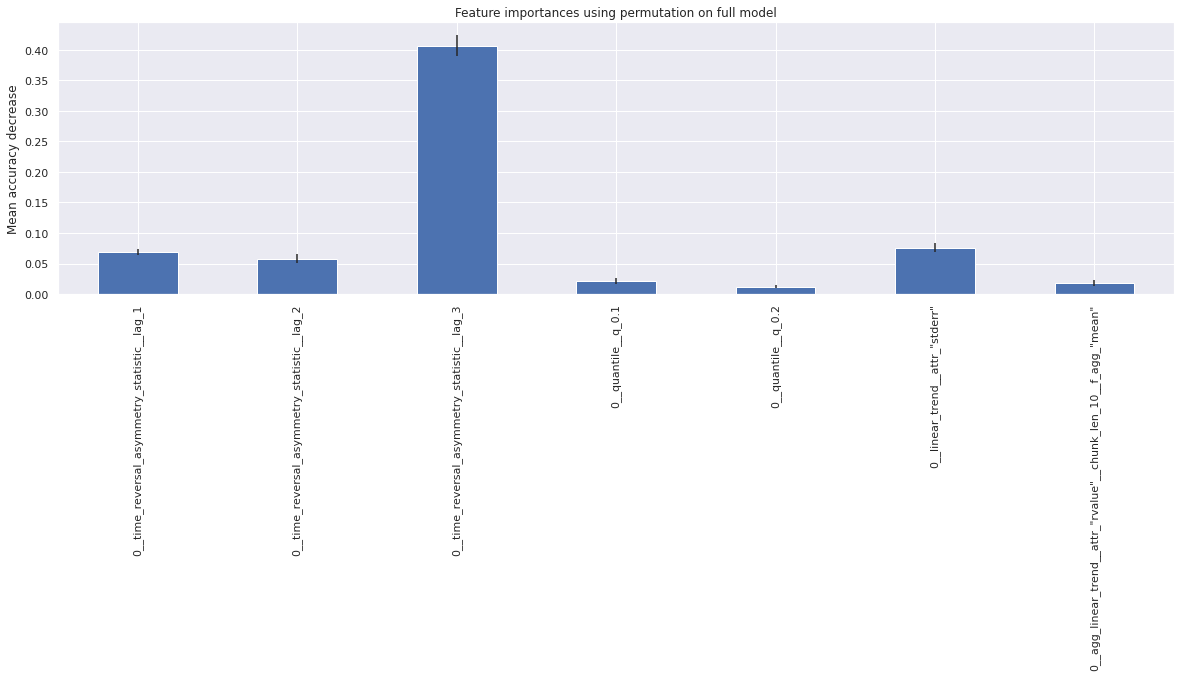

In [166]:
fig, ax = plt.subplots(figsize=(20, 5))

forest_importances[lperm_imp_idx].plot.bar(yerr=result.importances_std[lperm_imp_idx], ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [258]:
dates = [d for d, s in np.array(ts_index)[example_test_ind + 778]]

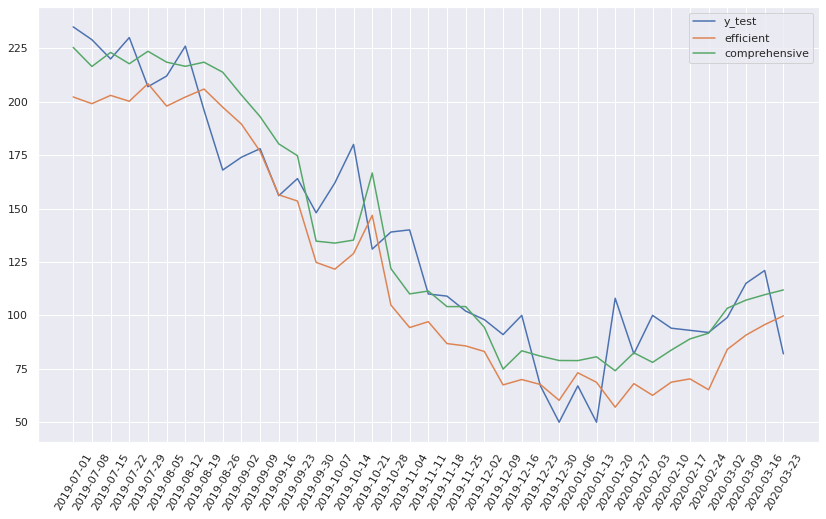

In [263]:
# картинка с предсказанием ряда
plt.figure(figsize=(14, 8))
plt.plot(dates, y_test[example_test_ind], label='y_test')
plt.plot(dates, y_pred[example_test_ind], label='efficient')
plt.plot(dates, (y_large_pred[example_test_ind]), label='comprehensive')
plt.xticks(rotation=60)
plt.legend()